# Learning and defining a causal model

### First we need to import some modules

In [11]:
# helper cell
#!pip install seaborn

ERROR: Could not find a version that satisfies the requirement seaborn (from versions: none)
ERROR: No matching distribution found for seaborn


In [4]:
import os 
from pprint import pprint

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#import pgmpy.models

%matplotlib inline

###  read the IBM Employee Attition Dataset 

In [28]:
data = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
pprint(list(data.columns))
data.head()


['Age',
 'Attrition',
 'BusinessTravel',
 'DailyRate',
 'Department',
 'DistanceFromHome',
 'Education',
 'EducationField',
 'EmployeeCount',
 'EmployeeNumber',
 'EnvironmentSatisfaction',
 'Gender',
 'HourlyRate',
 'JobInvolvement',
 'JobLevel',
 'JobRole',
 'JobSatisfaction',
 'MaritalStatus',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'Over18',
 'OverTime',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StandardHours',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


### get rid of unneccessary columns:


In [29]:
# Employee Count and StandardHours contain 1 resp. 80 for every record, so we can drop them
unnecessary_columns = ["EmployeeCount", "StandardHours"] 
data = data.drop(columns=unnecessary_columns)

### numerical and categorical variables:
most of the variables are numerical - either by by their "own nature" or by being already transformed to an integer (ordinal) scale. Others are still of categorical, i.e. string type - we can identify those by checking for "dtype == object" 

In [30]:
categorical_variables = [col for col in data.columns if data.loc[:, col].dtype == "object"]
print(categorical_variables)
data.loc[:, categorical_variables].head()

['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']


,Attrition,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
0,Yes,Travel_Rarely,Sales,Life Sciences,Female,Sales Executive,Single,Y,Yes
1,No,Travel_Frequently,Research & Development,Life Sciences,Male,Research Scientist,Married,Y,No
2,Yes,Travel_Rarely,Research & Development,Other,Male,Laboratory Technician,Single,Y,Yes
3,No,Travel_Frequently,Research & Development,Life Sciences,Female,Research Scientist,Married,Y,Yes
4,No,Travel_Rarely,Research & Development,Medical,Male,Laboratory Technician,Married,Y,No


as we can see, many of the categorical (object type) variables are of boolean nature. we can transform these onto oridnal (0/1) variables

In [44]:
boolean_variables = [
    "Attrition",
    "Gender",
    "Over18",
    "OverTime"
]
for var in boolean_variables:
    data.loc[:, var] = pd.factorize(data.loc[:, var])[0]

In [43]:
pd.factorize(data.loc[:, var])

(array([0, 1, 0, ..., 1, 1, 1]), Index(['Yes', 'No'], dtype='object'))

In [41]:
data.BusinessTravel.unique()

array(['Travel_Rarely', 'Travel_Frequently', 'Non-Travel'], dtype=object)

in the case of BusinessTravel we can map the values "Non-Travel", "Travel_Rarely", "Travel-Frequently" to the ordinal scale 0,1,2:

In [48]:
data.BusinessTravel = data.BusinessTravel.replace({
    "Non-Travel": 0, 
    "Travel_Rarely": 1,
    "Travel_Frequently": 2}
    )

### Now we can hava a look at the correlation matrix

In [52]:
correlation = data.corr()
#correlation['OverTime'].sort_values()
correlation

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Age,1.000000,0.159205,-0.011807,0.010661,-0.001686,0.208034,-0.010145,0.010146,-0.036311,0.024287,...,0.001904,0.053535,0.037510,0.680381,-0.019621,-0.021490,0.311309,0.212901,0.216513,0.202089
Attrition,0.159205,1.000000,-0.127006,0.056652,-0.077924,0.031373,0.010577,0.103369,-0.029453,0.006846,...,-0.002889,0.045872,0.137145,0.171063,0.059478,0.063939,0.134392,0.160545,0.033019,0.156199
BusinessTravel,-0.011807,-0.127006,1.000000,-0.015539,-0.009696,-0.008670,-0.018538,-0.011310,-0.044896,-0.004164,...,0.001683,0.008926,-0.028257,0.007972,0.016357,0.004209,0.005212,-0.005336,0.005222,-0.000229
DailyRate,0.010661,0.056652,-0.015539,1.000000,-0.004985,-0.016806,-0.050990,0.018355,-0.011716,0.023381,...,0.000473,0.007846,0.042143,0.014515,0.002453,-0.037848,-0.034055,0.009932,-0.033229,-0.026363
DistanceFromHome,-0.001686,-0.077924,-0.009696,-0.004985,1.000000,0.021042,0.032916,-0.016075,-0.001851,0.031131,...,0.027110,0.006557,0.044872,0.004628,-0.036942,-0.026556,0.009508,0.018845,0.010029,0.014406
Education,0.208034,0.031373,-0.008670,-0.016806,0.021042,1.000000,0.042070,-0.027128,-0.016547,0.016775,...,-0.024539,-0.009118,0.018422,0.148280,-0.025100,0.009819,0.069114,0.060236,0.054254,0.069065
EmployeeNumber,-0.010145,0.010577,-0.018538,-0.050990,0.032916,0.042070,1.000000,0.017621,0.022556,0.035179,...,-0.020359,-0.069861,0.062227,-0.014365,0.023603,0.010309,-0.011240,-0.008416,-0.009019,-0.009197
EnvironmentSatisfaction,0.010146,0.103369,-0.011310,0.018355,-0.016075,-0.027128,0.017621,1.000000,0.000508,-0.049857,...,-0.029548,0.007665,0.003432,-0.002693,-0.019359,0.027627,0.001458,0.018007,0.016194,-0.004999
Gender,-0.036311,-0.029453,-0.044896,-0.011716,-0.001851,-0.016547,0.022556,0.000508,1.000000,-0.000478,...,-0.013859,0.022868,0.012716,-0.046881,-0.038787,-0.002753,-0.029747,-0.041483,-0.026985,-0.030599
HourlyRate,0.024287,0.006846,-0.004164,0.023381,0.031131,0.016775,0.035179,-0.049857,-0.000478,1.000000,...,-0.002172,0.001330,0.050263,-0.002334,-0.008548,-0.004607,-0.019582,-0.024106,-0.026716,-0.020123


<AxesSubplot:>

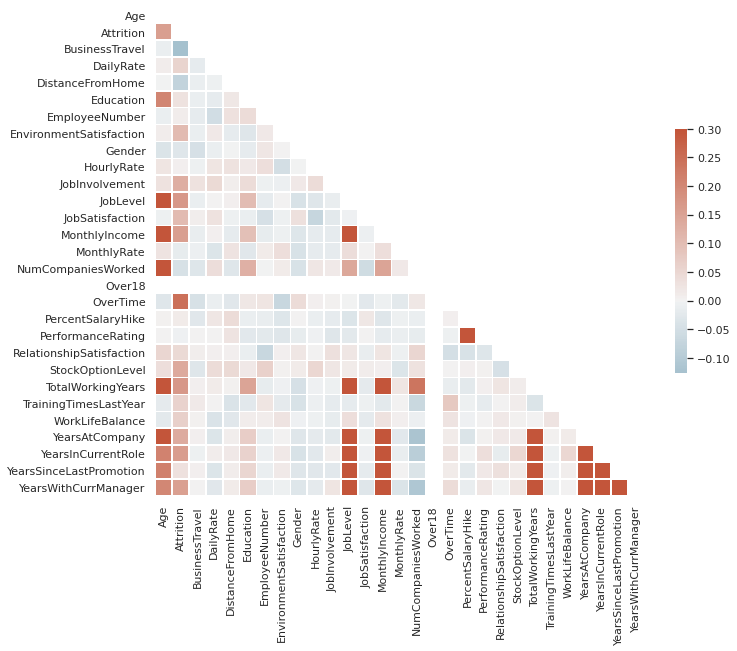

In [53]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")



# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## linear regression for Attrition
let's now try to run a linear regression on attrition

In [99]:
import sklearn.linear_model

numerical_variables = [col for col in data.columns if data.loc[:, col].dtype != "object"]
model = sklearn.linear_model.LogisticRegression()
y = data["Attrition"]
X = data.loc[:, numerical_variables].drop("Attrition", axis=1)
feature_names = X.columns
model.fit(X=X, y=y)

/mnt/c/Users/maximilian.kurthen/OneDrive - b.telligent/Projects/2021_01_SpringerFachbuch/caus_inf/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [100]:
dir(model)

['C',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_n_features',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_predict_proba_lr',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_data',
 'class_weight',
 'classes_',
 'coef_',
 'decision_function',
 'densify',
 'dual',
 'fit',
 'fit_intercept',
 'get_params',
 'intercept_',
 'intercept_scaling',
 'l1_ratio',
 'max_iter',
 'multi_class',
 'n_features_in_',
 'n_iter_',
 'n_jobs',
 'penalty',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'random_state',
 'score',
 'set_params',
 'solver',
 'sparsify',
 'tol',
 'verbose',
 'w

In [102]:
most_important_features = np.abs(model.coef_[0]).argsort()[::-1]
feature_names[most_important_features]

#model.coef_[most_important_features]
#most_important_features

Index(['DistanceFromHome', 'YearsInCurrentRole', 'YearsWithCurrManager',
       'NumCompaniesWorked', 'Age', 'YearsAtCompany',
       'YearsSinceLastPromotion', 'OverTime', 'JobSatisfaction',
       'TotalWorkingYears', 'EnvironmentSatisfaction', 'StockOptionLevel',
       'JobInvolvement', 'TrainingTimesLastYear', 'BusinessTravel',
       'RelationshipSatisfaction', 'WorkLifeBalance', 'PercentSalaryHike',
       'JobLevel', 'Gender', 'PerformanceRating', 'Education', 'DailyRate',
       'MonthlyIncome', 'EmployeeNumber', 'MonthlyRate', 'HourlyRate',
       'Over18'],
      dtype='object')

In [90]:
np.abs(model.predict(X) - y).sum()

232

In [95]:
import sklearn.neural_network
model = sklearn.neural_network.MLPClassifier()
model.fit(X=X, y=y)
np.abs(model.predict(X) - y).sum()

393

In [96]:
model.coefs_

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_backprop',
 '_check_n_features',
 '_compute_loss_grad',
 '_estimator_type',
 '_fit',
 '_fit_lbfgs',
 '_fit_stochastic',
 '_forward_pass',
 '_forward_pass_fast',
 '_get_param_names',
 '_get_tags',
 '_init_coef',
 '_initialize',
 '_label_binarizer',
 '_loss_grad_lbfgs',
 '_more_tags',
 '_no_improvement_count',
 '_optimizer',
 '_partial_fit',
 '_random_state',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_unpack',
 '_update_no_improvement_count',
 '_validate_data',
 '_validate_hyperparameters',
 '_validate_input',
 'activation',
 'alpha

In [98]:
def get_feature_importance(j, n):
    global model
    s = accuracy_score(y_test, y_pred) # baseline score
    total = 0.0
    for i in range(n):
        perm = np.random.permutation(range(X_test.shape[0]))
        X_test_ = X_test.copy()
        X_test_[:, j] = X_test[perm, j]
        y_pred_ = model.predict(X_test_)
        s_ij = accuracy_score(y_test, y_pred_)
        total += s_ij
    return s - total / n